In [ ]:
#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #"" for CPU
import tensorflow as tf
from tensorflow import keras

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [1]:
from os import *
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/')

In [2]:
dataDir = getcwd() + '/data'
files = listdir(dataDir)
files[0:5]

['RW_20140601-0050.asc',
 'RW_20140601-0150.asc',
 'RW_20140601-0250.asc',
 'RW_20140601-0350.asc',
 'RW_20140601-0450.asc']

In [3]:
totalLength = len(files)
totalLength

720

In [4]:
#array of inputs and outputs (predictions of the network)
inputs = np.empty((totalLength,900,900))

In [13]:
for i, file in enumerate(files):
    clear_output(wait=True)
    print(f"[{i+1}/{totalLength}]")
    ascii_grid = np.loadtxt(f"data/{files[i]}", skiprows=6)
    inputs[i] = ascii_grid
    if i == 5:
        break

[6/720]


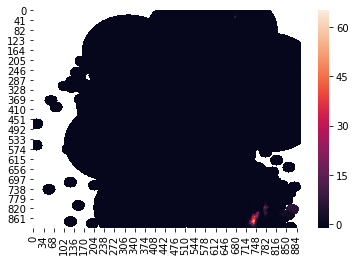

In [60]:
d = inputs[1]
sns.heatmap(d, mask=d<0)

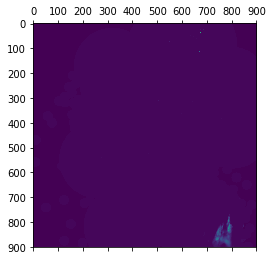

In [58]:
plt.matshow(inputs[0])